In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

"""создадим фунцию для отрисовки p-value

на вход она принимает 
 - массив из значений pvalue
 - массив с количеством наблюдений, на которых эти значения посчитали
 - значение alpha, если не передавать, по дефолту альфа = 0.05

"""
def print_cum_pval(pval_periods, pval_range, alpha = 0.05):
    plt.figure(1, figsize = (10,4))
    plt.plot(pval_periods, pval_range)
    plt.plot(pval_periods, [alpha]*len(pval_periods), '--', alpha = 0.5, label = 'alpha')
    plt.ylabel('p-value')
    plt.xlabel('Number of observations')
    plt.ylim(0, 1)
    plt.title("Cumulative p-value")
    plt.show()

"""создадим фукнцию для итеративного подсчета p-value 

на вход принимает 
- функция для подсчета pvalue. Можно отдать что-то из пакета scipy, например, stats.ks_2samp, или самописную
- group_A, group_B - датафреймы со значениями метрики в тестовой и контрольной группе
optional:
- pval_periods - массив с количеством наблюдений, на которых хотим посчитать pvalue
- значение alpha
- plot - нужно ли строить график "накопительного" p-value 
"накопительного" - так как копим только наблюдения, p-value не суммируем по времени
- return_values - нужно ли вернуть массив со значениеми pvalue и массив с количеством наблюдений

возвращает
-  массив с количеством наблюдений и массив со значениеми pvalue, если выбрано return_values = True
"""
def get_cum_pval(test_func, group_A, group_B, pval_periods = None, alpha = 0.05, plot = True, return_values = False):
    pval_range = []
    if not pval_periods:
        max_point = min(len(group_A), len(group_B))
        step = max(max_point//100, 1)
        pval_periods = range(1, max_point, step)
        
    for t in tqdm(range(len(pval_periods))):
        i = pval_periods[t]
        s, pval = test_func(group_A.head(i), group_B.head(i))
        pval_range.append(pval)
    
    if plot:
        print_cum_pval(pval_periods, pval_range, alpha)
    if return_values:
        return pval_periods, pval_range
    
""" создадим фукнцию для bootstrapping-а выборок
на вход принимает 
- data_column_1 и data_column_2 - dataframe со значениями метрик в группе 1 и группе 2
optional
- boot_it - количество бутстреп-итераций, по дефолту 1000
- statistic - какую метрику считаем в подвыборках, по дефолту - среднее
- bootstrap_conf_level - уровень значимости, по дефолту 0.95

возвращает 
- массив с dataframe данных бутстрепа (по дефолту - средние поэлементных разностей псевдовыборок) и квантилями оцененной метрики
- значение p-value на выбранном уровне значимости
"""
def get_bootstrap(data_column_1, data_column_2, boot_it = 1000, statistic = np.mean, bootstrap_conf_level = 0.95):
    boot_data = []
    for i in range(boot_it):
        samples_1 = data_column_1.sample(len(data_column_1), replace = True).values
        samples_2 = data_column_2.sample(len(data_column_2), replace = True).values
        boot_data.append(statistic(samples_1 - samples_2))
    
    pd_boot_data = pd.DataFrame(boot_data)
    
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
    
    negative_cnt  = len(pd_boot_data[pd_boot_data<=0].dropna())
    positive_cnt  = len(pd_boot_data[pd_boot_data>=0].dropna())

    p_value = min(positive_cnt, negative_cnt)*2/boot_it
   
    return [pd_boot_data, quants], p_value

In [ ]:
#p.s. если при попытке что-то импортировать, вам выпадает ошибка об отсутствии нужного пакета, попробуйте 
# !pip install [название пакета]
# а так - помним: гугл - твой лучший друг :)

In [2]:
from scipy.stats import poisson
import matplotlib.pyplot as plt

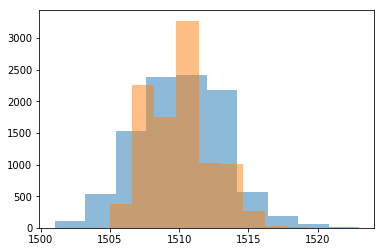

In [3]:
#сгенерируем данные для теста
control = poisson.rvs(mu  = 10, loc = 1500, size = 10000)
test =  poisson.rvs(mu  = 5, loc = 1505, size = 10000)
plt.hist(control, alpha = 0.5)
plt.hist(test, alpha = 0.5)
plt.show()

100%|██████████| 100/100 [01:35<00:00,  1.43s/it]


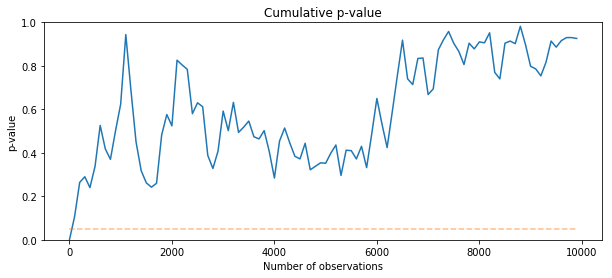

In [4]:
get_cum_pval(get_bootstrap, pd.DataFrame(control), pd.DataFrame(test))

Какие выводы можно сделать? Что необходимо посмотреть для окончательной уверенности?